In this kernel, we will use **EfficientNetB3** to produce **DeepDream** images. We will use **225 Bird Species** and **Best Artworks of All Time** datasets.

In [ ]:
!pip install -q efficientnet

In [ ]:
from efficientnet.tfkeras import EfficientNetB3
from efficientnet.tfkeras import preprocess_input
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
import tensorflow as tf
import numpy as np
from scipy.ndimage import gaussian_filter

import cv2
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

## Load Model

EfficientNetB3 block diagram is shown below. After input and stem layers, there are 7 blocks which are shown as gray boxes. Start and end layers of each block are shown. Dashed arrows inside boxes indicate that there are some layers not shown between start and end layers of each block.  

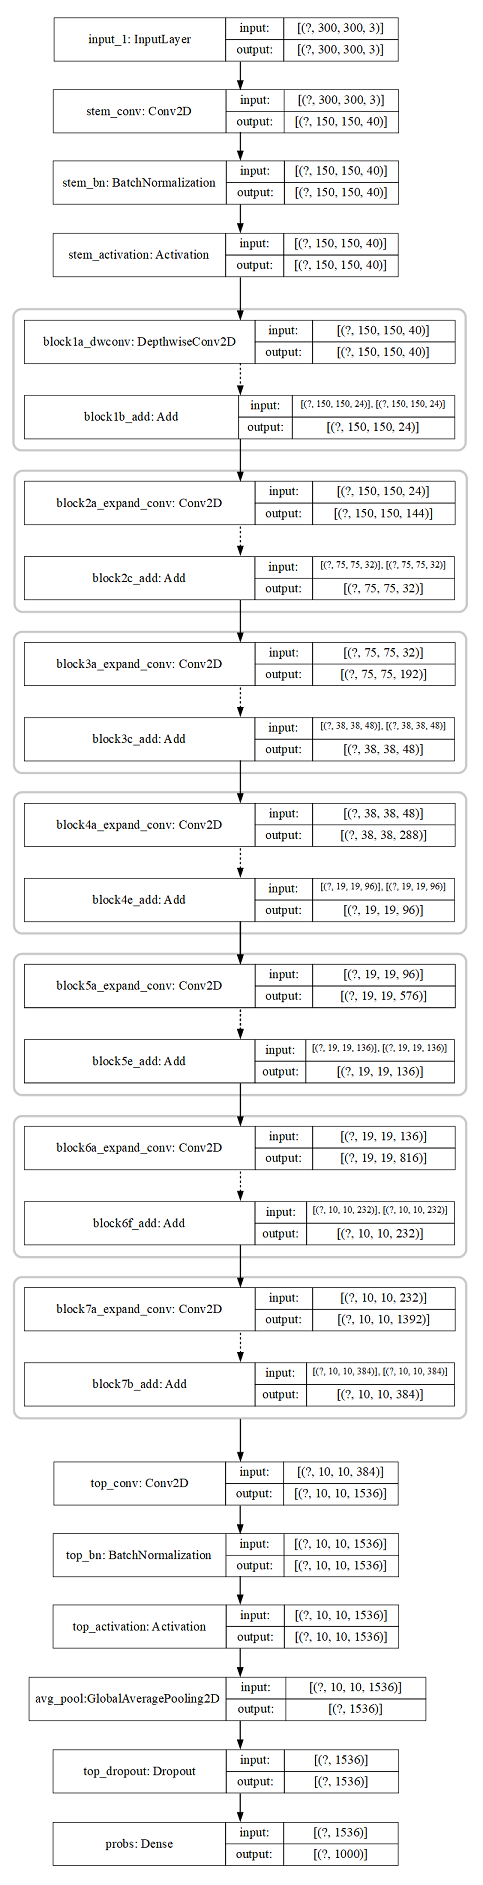

We load EfficientNetB3 excluding top with imagenet weights. avg_poll, top_dropout and probs layers are excluded.

In [ ]:
model = EfficientNetB3(include_top=False, weights="imagenet")

Without top layers, it has

* Total params: 10,783,528
* Trainable params: 10,696,232
* Non-trainable params: 87,296

Let's look at number of layers.

In [ ]:
len(model.layers)

## Get Outputs

We create another model in order to get the outputs of blocks 5, 6 and 7. 

In [ ]:
# we will take outputs of last 3 blocks
outputs = [model.get_layer("block5e_add").output,
           model.get_layer("block6f_add").output,
           model.get_layer("block7b_add").output]

model = Model(inputs=model.inputs, outputs=outputs)

## Load Input Images

In [ ]:
names = ["Flamingo", "Barn Owl",
         "Vincent van Gogh - Wheat Field with Cypresses",
         "Vincent van Gogh - The White Orchard"]
paths = ["/kaggle/input/100-bird-species/consolidated/FLAMINGO/012.jpg",         
         "/kaggle/input/100-bird-species/consolidated/BARN OWL/029.jpg",
         "/kaggle/input/best-artworks-of-all-time/images/images/"
           "Vincent_van_Gogh/Vincent_van_Gogh_109.jpg",
         "/kaggle/input/best-artworks-of-all-time/images/images/"
           "Vincent_van_Gogh/Vincent_van_Gogh_132.jpg"]

def read_images(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = image[...,::-1]
    return image
    
def plot_images(images):
    fig = plt.figure(constrained_layout = True, figsize=(10, 10))
    gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
    for i in range(4):
        y, x = i//2, i%2 
        ax = fig.add_subplot(gs[y,x]) 
        ax.imshow(np.uint8(images[i]))
        ax.axis("off")
        ax.title.set_text(names[i])

In [ ]:
images = []
for path in paths:
    images.append(read_images(path))
plot_images(images)

## Go with Gradient

When creating DeepDream images, the idea is to modify input image so as to maximize the activation of a specific feature map or maps. It's like asking the neural network what it wants to see as input. Neural network itself guides the input modification process.

While training neural networks, we aim to decrease loss and use gradient descent for this purpose. To maximize an activation, we use gradient ascent. 

The gradient of the activation with respect to input image is computed. Then we go along the gradient direction with a stepsize of learning_rate. This way, input image is modified iteratively. To handle this, we define gradient_ascent function below.

In [ ]:
learning_rate = 0.01
iterations = 150
def gradient_ascent(image, block_id):  
    image = tf.expand_dims(image, axis=0)
    for d in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(image)
            # get block activation maps
            maps = model(image)  
            strength = tf.reduce_mean(tf.abs(maps[block_id]))

        # get gradients stored in tape
        gradients = tape.gradient(strength, image)

        # normalize gradients
        gradients /= (tf.math.reduce_std(gradients) + 1e-10)

        # modify input image
        image += learning_rate * gradients

    return image[0]

After modifying input image, it needs to be deprocessed. When inputting an image into a neural network, image is preprocessed. This stage changes from model to model. In deprocessing, the steps of preprocessing are reversed.

efficientnet.tfkeras library uses preprocess_input function from keras.applications.imagenet_utils with mode="torch".

In [ ]:
def deprocess(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    image[..., 0] *= std[0]
    image[..., 1] *= std[1]
    image[..., 2] *= std[2]
    
    image[..., 0] += mean[0]
    image[..., 1] += mean[1]
    image[..., 2] += mean[2]
       
    image *= 255.0
    image = np.clip(image, 0, 255) 

    return image

Gradient ascent is applied to input image at different resolutions sequentially.

In [ ]:
img_size = tf.convert_to_tensor([(140, 140), (170, 170), (205, 205),
                     (245, 245), (300, 300), (355, 355), (425, 425),
                     (512, 512), (614, 614), (740, 740)])

def deepdream(image_in):
    results = []
    for block_id in range(len(outputs)):
        image = preprocess_input(image_in)
        image = tf.convert_to_tensor(image)
        for s in img_size:
            image = tf.image.resize(image, s) 
            image = gradient_ascent(image, block_id)
            
        results.append(deprocess(image.numpy()))
    return results

In [ ]:
titles = ["Original Image",
          "After maximizing the output of Block 5",
          "After maximizing the output of Block 6",
          "After maximizing the output of Block 7"]

def plot_results(image, results):
    image = cv2.resize(image, (448, 448), interpolation = cv2.INTER_CUBIC)
    fig = plt.figure(constrained_layout = True, figsize=(9, 32))
    gs = gridspec.GridSpec(nrows=4, ncols=1, figure=fig, height_ratios = [1,2,2,2])
    for i in range(4):
        y, x = i//1, i%1 
        ax = fig.add_subplot(gs[y,x])
        if i > 0:
            image = results[i-1]
        ax.imshow(np.uint8(image))
        ax.axis("off")
        ax.title.set_text(titles[i])

In [ ]:
results = deepdream(images[0])
plot_results(images[0], results)

In [ ]:
results = deepdream(images[1])
plot_results(images[1], results)

In [ ]:
results = deepdream(images[2])
plot_results(images[2], results)

In [ ]:
results = deepdream(images[3])
plot_results(images[3], results)